# Data Engineering with Apache Spark

## Project Overview
This project demonstrates data processing and analysis using Apache Spark, utilizing the MovieLens dataset to perform various data transformation and analysis tasks.

## Steps Performed

### Import Libraries

Importing the necessary libraries for data processing and visualization.


In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, count
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configure visualizations
%matplotlib inline
sns.set(style="darkgrid")

### Start Spark Session

Starting a spark session to enable data processing with PySpark. I also set the log level to `ERROR` to reduce verbosity.

In [31]:
# Path to log4j.properties file
log4j_conf_path = "/Users/brightdarko/Desktop/sparklong/log4j.properties"

# Start Spark session with log level set to ERROR using log4j.properties
spark = SparkSession.builder \
    .appName("Spark Data Processing") \
    .config("spark.driver.extraJavaOptions", f"-Dlog4j.configuration=file:{log4j_conf_path}") \
    .getOrCreate()

# Set log level to ERROR
spark.sparkContext.setLogLevel("ERROR")


### Load the Dataset

Loading the MovieLens dataset, which contains information about movies and ratings. The dataset is loaded from CSV files into Spark DataFrames.

In [5]:
# Load MovieLens dataset
ratings = spark.read.csv('/Users/brightdarko/Downloads/ml-latest-small/ratings.csv', header=True, inferSchema=True)
movies = spark.read.csv('/Users/brightdarko/Downloads/ml-latest-small/movies.csv', header=True, inferSchema=True)

# Show the first few rows
ratings.show(5)
movies.show(5)

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
+------+-------+------+---------+
only showing top 5 rows

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows



### Understand the Data

Printing the schema of the datasets and show summary statistics to understand the data better.

In [33]:
# Print schema of the datasets
ratings.printSchema()
movies.printSchema()


# Summary statistics
ratings.describe().show()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)

root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)

+-------+------------------+----------------+------------------+--------------------+
|summary|            userId|         movieId|            rating|           timestamp|
+-------+------------------+----------------+------------------+--------------------+
|  count|            100836|          100836|            100836|              100836|
|   mean|326.12756356856676|19435.2957177992| 3.501556983616962|1.2059460873684695E9|
| stddev| 182.6184914635004|35530.9871987003|1.0425292390606342|2.1626103599513078E8|
|    min|                 1|               1|               0.5|           828124615|
|    max|               610|          193609|               5.0|          1537799250|
+-------+-----------------

### Data Transformation and Analysis

Joining the ratings and movies datasets on the movieId column to combine the movie information with the ratings.

In [7]:
# Join ratings and movies datasets
movie_ratings = ratings.join(movies, on='movieId', how='inner')
movie_ratings.show(5)

+-------+------+------+---------+--------------------+--------------------+
|movieId|userId|rating|timestamp|               title|              genres|
+-------+------+------+---------+--------------------+--------------------+
|      1|     1|   4.0|964982703|    Toy Story (1995)|Adventure|Animati...|
|      3|     1|   4.0|964981247|Grumpier Old Men ...|      Comedy|Romance|
|      6|     1|   4.0|964982224|         Heat (1995)|Action|Crime|Thri...|
|     47|     1|   5.0|964983815|Seven (a.k.a. Se7...|    Mystery|Thriller|
|     50|     1|   5.0|964982931|Usual Suspects, T...|Crime|Mystery|Thr...|
+-------+------+------+---------+--------------------+--------------------+
only showing top 5 rows



### Calculate Average Rating for Each Movie

Calculating the average rating and the number of ratings for each movie to identify popular movies and their ratings.

In [8]:
# Calculate average rating for each movie
avg_ratings = movie_ratings.groupBy('title').agg(avg('rating').alias('avg_rating'), count('rating').alias('num_ratings'))
avg_ratings.show(5)


+--------------------+------------------+-----------+
|               title|        avg_rating|num_ratings|
+--------------------+------------------+-----------+
|       Psycho (1960)| 4.036144578313253|         83|
|Men in Black (a.k...| 3.487878787878788|        165|
|Gulliver's Travel...|               3.0|          3|
|Heavenly Creature...|3.9285714285714284|         21|
|    Elizabeth (1998)|3.6739130434782608|         23|
+--------------------+------------------+-----------+
only showing top 5 rows



### Filter Movies with More Than 100 Ratings

Filtering out movies with more than 100 ratings for a more focused analysis on popular movies.

In [38]:
# Filter movies with more than 100 ratings
popular_movies = avg_ratings.filter(col('num_ratings') > 100)
popular_movies.show(5)

+--------------------+------------------+-----------+
|               title|        avg_rating|num_ratings|
+--------------------+------------------+-----------+
|Men in Black (a.k...| 3.487878787878788|        165|
|Kill Bill: Vol. 2...| 3.868181818181818|        110|
|Eternal Sunshine ...|4.1603053435114505|        131|
|Dumb & Dumber (Du...|3.0601503759398496|        133|
|Indiana Jones and...| 3.638888888888889|        108|
+--------------------+------------------+-----------+
only showing top 5 rows



### Convert to Pandas for Visualization

Converting the results to a Pandas DataFrame for visualization and plot the top 10 movies by average rating.

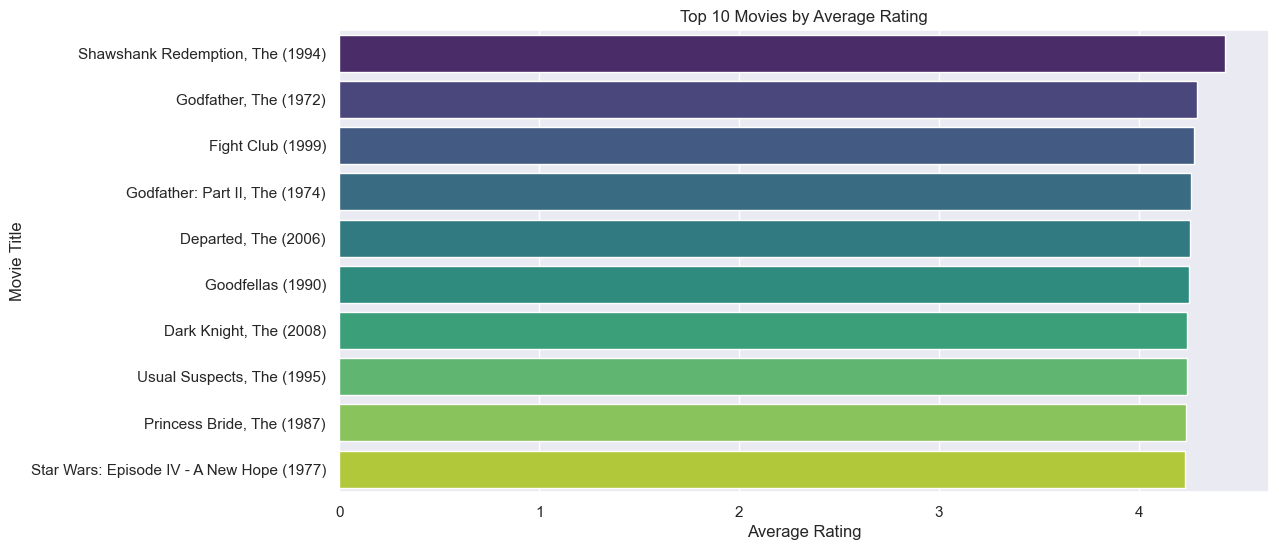

In [40]:
# Convert to Pandas DataFrame for visualization
popular_movies_pd = popular_movies.toPandas()

# Top 10 Movies by Average Rating
top_10_movies = popular_movies_pd.sort_values(by='avg_rating', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x='avg_rating', y='title', data=top_10_movies, palette='viridis', hue='title', dodge=False, legend=False)
plt.title('Top 10 Movies by Average Rating')
plt.xlabel('Average Rating')
plt.ylabel('Movie Title')
plt.show()
